In [1]:
from utils import sars2_genome_info, add_syn_mut_attribute, add_mut_accumulation_attr, add_del_accumulation_attr
from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats, DateToStr
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import requests
import json
from datetime import datetime, date
import calendar
import time
import math
import string
import requests
import csv

## The calculation of Accumulation of nonsynonymous and synonymy for SARS-CoV-2 region over time 

##### The accumulation of mutations in different regions of the genome is counted and plotted over time to show that some regions amass nonsynonymous substitions at higher rates than others.


Import the tree and convert to Bio Phylo format. This is a time-resolved phylogeny built from SARS-CoV-2 genomes sampled between March 2020 and September 2022. The phylogeny was constructed for a specific country with subsampled sequences and approximately 300 sequences maintained by the Nextstrain team, serving as genetic context. These sequences represented all Nextstrain clades annotated for SARS-CoV-2.We downloaded sequences maintained by the Nextstrain team as the genetic context, which can be found at https://data.nextstrain.org/files/ncov/open/reference/metadata.tsv.xz.

In [2]:
with open('/public/home/yly/nextstain_input_2209/ncov_country/ncov_country_2032/ncov_Denmark/auspice/ncov_Denmark-build.json') as f:
    tree_json = json.load(f)

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Get information about genome position and length of each gene 

In [3]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

Add information about synonymous mutations as an attribute of nodes on the tree

In [4]:
tree = add_syn_mut_attribute(tree)

/public/home/yly/.local/lib/python3.10/site-packages/Bio/Seq.py:2954: BiopythonDeprecationWarning: myseq.toseq() is deprecated; please use Seq(myseq) instead.
  warnings.warn(


Add an attribute to each node that gives the total number of mutations (synonymous SNPs, or nonsynonymous SNPs plus deletions) accumulated between the tree root and that node (including mutations on the node). 

In [5]:
tree = add_mut_accumulation_attr(tree)

Add an attribute to each node that lists deletions and nonsynonymous SNPs separately

In [6]:
tree = add_del_accumulation_attr(tree)

Make a list of regions of the genome to consider. Each element of the list is a tuple with the format: 
(region/type of mutation, node attribute name, gene length for normalizing mutation count, nonsynonymous or synonymous)

In [7]:
regions_to_consider = [('S1', 's1_accumulation', 'S1', 'nonsyn'), ('S1_synonymous', 's1_syn_accumulation', 'S1', 'syn'), 
                        ('S2', 's2_accumulation', 'S2', 'nonsyn'),('S2_synonymous', 's2_syn_accumulation', 'S2', 'syn'), 
                       ('N', 'n_accumulation', 'N', 'nonsyn'),('N_synonymous', 'n_syn_accumulation', 'N', 'syn'), 
                       ('E', 'e_accumulation', 'E', 'nonsyn'), ('E_synonymous', 'e_syn_accumulation', 'E', 'syn'), 
                       ('M', 'm_accumulation', 'M', 'nonsyn'),('M_synonymous', 'm_syn_accumulation', 'M', 'syn'), 
                       ('ORF1a', 'orf1a_accumulation', 'ORF1a', 'nonsyn'),('ORF1a_synonymous', 'orf1a_syn_accumulation', 'ORF1a', 'syn'), 
                       ('ORF1b', 'orf1b_accumulation', 'ORF1b', 'nonsyn'),('ORF1b_synonymous', 'orf1b_syn_accumulation', 'ORF1b', 'syn'),
                       ('ORF3a', 'orf3a_accumulation', 'ORF3a', 'nonsyn'),('ORF3a_synonymous', 'orf3a_syn_accumulation', 'ORF3a', 'syn'),
                       ('ORF6', 'orf6_accumulation', 'ORF6', 'nonsyn'),('ORF6_synonymous', 'orf6_syn_accumulation', 'ORF6', 'syn'),
                       ('ORF7a', 'orf7a_accumulation', 'ORF7a', 'nonsyn'),('ORF7a_synonymous', 'orf7a_syn_accumulation', 'ORF7a', 'syn'),
                       ('ORF7b', 'orf7b_accumulation', 'ORF7b', 'nonsyn'),('ORF7b_synonymous', 'orf7b_syn_accumulation', 'ORF7b', 'syn'),
                       ('ORF8', 'orf8_accumulation', 'ORF8', 'nonsyn'),('ORF8_synonymous', 'orf8_syn_accumulation', 'ORF8', 'syn'),
                       ('ORF9b', 'orf9b_accumulation', 'ORF9b', 'nonsyn'),('ORF9b_synonymous', 'orf9b_syn_accumulation', 'ORF9b', 'syn'),
                       ('RdRp', 'rdrp_accumulation', 'RdRp', 'nonsyn'),  ('RdRp_synonymous', 'rdrp_syn_accumulation', 'RdRp', 'syn')]


In [8]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [9]:
# find the end date of the build

last_timepoint = 0
for node in tree.find_clades():
    if node.node_attrs['num_date']['value'] > last_timepoint:
        last_timepoint = node.node_attrs['num_date']['value']

last_date = DateToStr(last_timepoint)
last_date = datetime.strptime(last_date, '%b-%d-%Y')

In [10]:
time_windows = []

for year in [2020, 2021,2022]:
    for month in range(1,13):
        # change add_window to True if window is before the end of the build
        add_window = False
        
        window_start = date(year, month, 1)
        if month < 12:
            last_day_of_month = calendar.monthrange(year, month+1)[1]
            window_end = date(year, month+1, last_day_of_month)
            window_midpoint = date(year, month+1, 1)
        elif month ==12:
            last_day_of_month = calendar.monthrange(year+1, 1)[1]
            window_end = date(year+1, 1, last_day_of_month)
            window_midpoint = date(year+1, 1, 1)
            

        if year < last_date.year:
            add_window = True

        # end time windows at build date
        elif year == last_date.year:
            if month < (last_date.month - 1):
                add_window = True

            elif month == (last_date.month - 1):
                window_end = last_date
                add_window = True

        if add_window ==True:        
            time_windows.append({'window_start_decimal': toYearFraction(window_start), 
                            'window_end_decimal': toYearFraction(window_end), 
                            'window_start': datetime.strftime(window_start, '%b-%d-%Y'), 
                            'window_end': datetime.strftime(window_end, '%b-%d-%Y'), 
                            'window_midpoint': datetime.strftime(window_midpoint, '%b-%d-%Y')})
                

Make a tidy dataframe to plot: 
1) accumulation of mutations over time for each region of the genome

2) mutation accumulation versus logistic growth

In [11]:
# initialize list to store relevant information for Fig1A and B
muts_information = []

# look at divergence within time window
for x in range(0, len(time_windows)):
    start_date = float(time_windows[x]['window_start_decimal'])
    end_date = float(time_windows[x]['window_end_decimal'])

    # only look at internal nodes
    for node in tree.find_clades(terminal=False):
        if node.node_attrs['num_date']['value'] >= start_date and node.node_attrs['num_date']['value'] <= end_date:

            # only nodes within 6 weeks of May 15 have logistic growth rates
            #logistic_growth = None
            #if "logistic_growth" in node.node_attrs:
            #    logistic_growth = node.node_attrs["logistic_growth"]["value"]

            if hasattr(node, "node_attrs"):
                # get inferred node date
                node_date = node.node_attrs["num_date"]["value"]

                # get emerging lineage assignment of node
                if 'emerging_lineage' in node.node_attrs:
                    emerging_lineage = node.node_attrs['emerging_lineage']['value']
                    emerging_lineage = convert_linege_names(emerging_lineage)
                    clade_membership = node.node_attrs['clade_membership']['value']
                    mutational_fitness = node.node_attrs['mutational_fitness']['value']
                    S1_mutations = node.node_attrs['S1_mutations']['value']
                    node_country = node.node_attrs['country']['value']
                    #manuscript_lineage = node.node_attrs['manuscript_lineage']['value']

                    # make tidy df for seaborn plotting
                    for r in regions_to_consider:
                        # there are no synonymous deletions, but S1 deletions will be stored with S1_syn mut information-> these will not be plotted
                        # add figure_lineage key to group
                        muts_information.append({'clade': node.name, 
                                                 'node_date': node_date,
                                                 'emerging_lineage': emerging_lineage,
                                                 'node_country':node_country,
                                                 #'manuscript_lineage': manuscript_lineage,
                                                 'clade_membership': clade_membership,
                                                 'mutational_fitness': mutational_fitness,
                                                 'S1_mutations': S1_mutations,
                                                 'mut_location': r[0],
                                                 'num_muts': node.node_attrs[r[1]],
                                                 'muts_per_codon': node.node_attrs[r[1]] / gene_lengths_aa[r[2]],
                                                 'num_deletions': node.node_attrs['deletion_accumulation'][r[2]],
                                                 'dels_per_codon': node.node_attrs['deletion_accumulation'][r[2]] / gene_lengths_aa[r[2]],
                                                 'snps_per_codon': node.node_attrs['nonsyn_snps_accumulation'][r[2]] / gene_lengths_aa[r[2]],
                                                 #'logistic_growth': logistic_growth,
                                                 'window_start': time_windows[x]['window_start'],
                                                 'window_start_decimal': time_windows[x]['window_start_decimal'],
                                                 'window_end': time_windows[x]['window_end'],
                                                 'window_midpoint': time_windows[x]['window_midpoint']})

# make list into dataframe
muts_information_df = pd.DataFrame(muts_information)


In [12]:
muts_information_df

,clade,node_date,emerging_lineage,node_country,clade_membership,mutational_fitness,S1_mutations,mut_location,num_muts,muts_per_codon,num_deletions,dels_per_codon,snps_per_codon,window_start,window_start_decimal,window_end,window_midpoint
0,NODE_0000000,2020.003614,19A,Denmark,19A,0.000000,0.0,S1,0,0.000000,0,0.000000,0.000000,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020
1,NODE_0000000,2020.003614,19A,Denmark,19A,0.000000,0.0,S1_synonymous,0,0.000000,0,0.000000,0.000000,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020
2,NODE_0000000,2020.003614,19A,Denmark,19A,0.000000,0.0,S2,0,0.000000,0,0.000000,0.000000,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020
3,NODE_0000000,2020.003614,19A,Denmark,19A,0.000000,0.0,S2_synonymous,0,0.000000,0,0.000000,0.000000,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020
4,NODE_0000000,2020.003614,19A,Denmark,19A,0.000000,0.0,N,0,0.000000,0,0.000000,0.000000,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264511,NODE_0006268,2022.683336,22B (Omicron),Denmark,22B (Omicron),3.123655,28.0,ORF8_synonymous,0,0.000000,0,0.000000,0.000000,Sep-01-2022,2022.665753,Oct-31-2022,Oct-01-2022
264512,NODE_0006268,2022.683336,22B (Omicron),Denmark,22B (Omicron),3.123655,28.0,ORF9b,5,0.051020,12,0.122449,-0.071429,Sep-01-2022,2022.665753,Oct-31-2022,Oct-01-2022
264513,NODE_0006268,2022.683336,22B (Omicron),Denmark,22B (Omicron),3.123655,28.0,ORF9b_synonymous,0,0.000000,12,0.122449,-0.071429,Sep-01-2022,2022.665753,Oct-31-2022,Oct-01-2022
264514,NODE_0006268,2022.683336,22B (Omicron),Denmark,22B (Omicron),3.123655,28.0,RdRp,1,0.001073,0,0.000000,0.001073,Sep-01-2022,2022.665753,Oct-31-2022,Oct-01-2022


In [13]:
muts_information_df
muts_information_df['country'] = 'Denmark'
muts_information_df['seed'] = '2032'
muts_information_df.to_csv('mutation_row_df_Denmark_2032.csv', index=False)

In [14]:
# double check that plotted 95% confidence intervals are correct

import scipy.stats as stats  # Import the stats module from scipy

# Group the dataframe by 'window_start' and calculate mean and standard error of the mean (SEM) for each 'location'
grouped_mut = muts_information_df.groupby(['mut_location', 'window_start','window_start_decimal']).agg({'num_muts': ['mean', 'sem']}, skipna=True)

# Calculate the 95% confidence interval using the t-distribution with 2 degrees of freedom (assuming small sample size)
conf_interval = stats.t.ppf(0.975, df=2) * grouped_mut[('num_muts', 'sem')]

# Add the mean and confidence interval to the grouped DataFrame
grouped_mut[('num_muts', 'conf_interval_lower')] = grouped_mut[('num_muts', 'mean')] - conf_interval
grouped_mut[('num_muts', 'conf_interval_upper')] = grouped_mut[('num_muts', 'mean')] + conf_interval

# Reset the index and move 'location' back as a column
grouped_mut.reset_index(inplace=True)
#grouped = grouped[['location', 'window_start', ('dn/ds', 'mean'), ('dn/ds', 'sem'), ('dn/ds', 'conf_interval_lower'), ('dn/ds', 'conf_interval_upper')]]
#print(type(grouped))

#olnames
new_columns = ['location', 'window_start','window_start_decimal' ,'muts_num_mean', 'muts_num_sem', 'muts_num_ci_lower',
               'muts_num_ci_upper']
grouped_mut.set_axis(new_columns, axis=1, inplace=True)

grouped_mut

/tmp/ipykernel_3955/1560941166.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  grouped_mut.set_axis(new_columns, axis=1, inplace=True)


,location,window_start,window_start_decimal,muts_num_mean,muts_num_sem,muts_num_ci_lower,muts_num_ci_upper
0,E,Apr-01-2020,2020.248634,0.017045,0.006909,-0.012682,0.046773
1,E,Apr-01-2021,2021.246575,0.069204,0.014955,0.004856,0.133552
2,E,Apr-01-2022,2022.246575,0.995305,0.004695,0.975105,1.015505
3,E,Aug-01-2020,2020.581967,0.000000,0.000000,0.000000,0.000000
4,E,Aug-01-2021,2021.580822,0.159259,0.022310,0.063265,0.255253
...,...,...,...,...,...,...,...
919,S2_synonymous,Oct-01-2020,2020.748634,0.361538,0.029853,0.233089,0.489988
920,S2_synonymous,Oct-01-2021,2021.747945,0.537572,0.027460,0.419421,0.655723
921,S2_synonymous,Sep-01-2020,2020.666667,0.292308,0.025268,0.183589,0.401027
922,S2_synonymous,Sep-01-2021,2021.665753,0.389241,0.027835,0.269475,0.509006


In [15]:
grouped_mut['country'] = 'Denmark'
grouped_mut['seed'] = '2032'
grouped_mut.to_csv('mutation_ci_num_Denmark_2032.csv', index=False)

Now plot Figure: nonsynonymous and synonymous mutation for S1 and S2 accumulation over time. Just for interest- This figure is not included in the paper.

In [16]:
def plot_fig1ab(filename=None):
    
    #only color alpha, beta, delta, gamma, and group other vois
    # the basal lineage will be gray
    cmap = {'Alpha': "#5E1D9D", 'Beta':"#416CCE",'Delta':"#89BB6B",
            'Gamma':"#E14F2A", 'other VOI':"#DDAA3C",'basal': "#ABABAB"}


    # dictionary to convert labels to more readable labels
    readable_labels = {'nonsyn': 'Nonsynonymous', 'syn': 'Synonymous'}
    # whether or not to plot legend, based on subplot index
    plot_legend = {**{x:False for x in range(0,4)}, **{4:True}}
    
    # initialize figure format
    fig, axes= plt.subplots(2,2, figsize=(8,8), sharey=True)
    plt.tight_layout()
    sns.set_style('white')
    
    # just want to plot S1 nonsyn, S1 syn and RdRp
    fig1_categories = regions_to_consider[:4]
    
    for i, ax in enumerate(axes.flat):
        j = i
        x_axis_variable = "node_date"
        x_label = "Date"
       
            
        ax = sns.scatterplot(x=x_axis_variable, y="muts_per_codon", 
                      hue_order= list(cmap.keys()), palette=cmap,
                      data = muts_information_df[muts_information_df['mut_location']==fig1_categories[j][0]], 
                      ax=ax, legend=plot_legend[i])
        sns.regplot(x=x_axis_variable, y="muts_per_codon", scatter=False, ax=ax, 
                    data = muts_information_df[muts_information_df['mut_location']==fig1_categories[j][0]], 
                    line_kws={"color":'black'}, ci=95)
        ax.set_xlabel(x_label, fontsize = 14)
        ax.set_title(f'{fig1_categories[j][2]} {readable_labels[fig1_categories[j][3]]} (Denmark)', 
                     fontsize = 16, fontweight='bold')
        
        # run linear regression on the plot
        slope, r_value = get_linear_reg_stats(muts_information_df, fig1_categories[j][0], 
                                              x_axis_variable, 'muts_per_codon')
        
        # label slope and r-value. 
        if i<28:
            ax.annotate(f'{format(slope, "10.2E")} muts per codon per year \n $r$: {r_value}', 
                        xy=(2020.0,0.0250), size=14, va='top', ha='left')
      
    
    
    # Add secondary axis showing absolute number of mutations for panel A subplots
    ax_1 = fig.axes[0].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_2 = fig.axes[1].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_3 = fig.axes[2].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_4 = fig.axes[3].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
   
    
           
    # label y axis of the outer subplots
    for i, ax in enumerate(axes.flat):
        if i in [0,4]:
            ax.set_ylabel('Mutations per codon', fontsize = 14)
        if i == 2:
            ax_3.set_ylabel('Number of mutations', fontsize = 14, color='#ABABAB')
  
    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    # adjust spacing between plots
    plt.subplots_adjust(hspace=0.4, wspace=0.1)
    
    # adjust fontsize and axis limits
    for i, ax in enumerate(axes.flat):
        if i<4:
            #ax.set_ylim(-0.0025, 0.02)
            ax.set_xticks([p for p in ax.get_xticks()])
            #ax.set_xlim(2019.9, 2021.38)
            ax.set_xticklabels([DateToStr(float(t)) for t in ax.get_xticks()], rotation=30)
            plt.setp(ax.get_xticklabels(), fontsize=10)
            plt.setp(ax.get_yticklabels(), fontsize=12)
    
    
    # add figure labels
    plt.figtext(-0.05, 0.98, 'A', fontsize=24, fontweight='bold')
    #plt.figtext(-0.05, 0.48, 'B', fontsize=24, fontweight='bold')
    

    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')
#plt.show()        

/tmp/ipykernel_3955/521773658.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x=x_axis_variable, y="muts_per_codon",
/tmp/ipykernel_3955/521773658.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x=x_axis_variable, y="muts_per_codon",
/tmp/ipykernel_3955/521773658.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x=x_axis_variable, y="muts_per_codon",
/tmp/ipykernel_3955/521773658.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x=x_axis_variable, y="muts_per_codon",


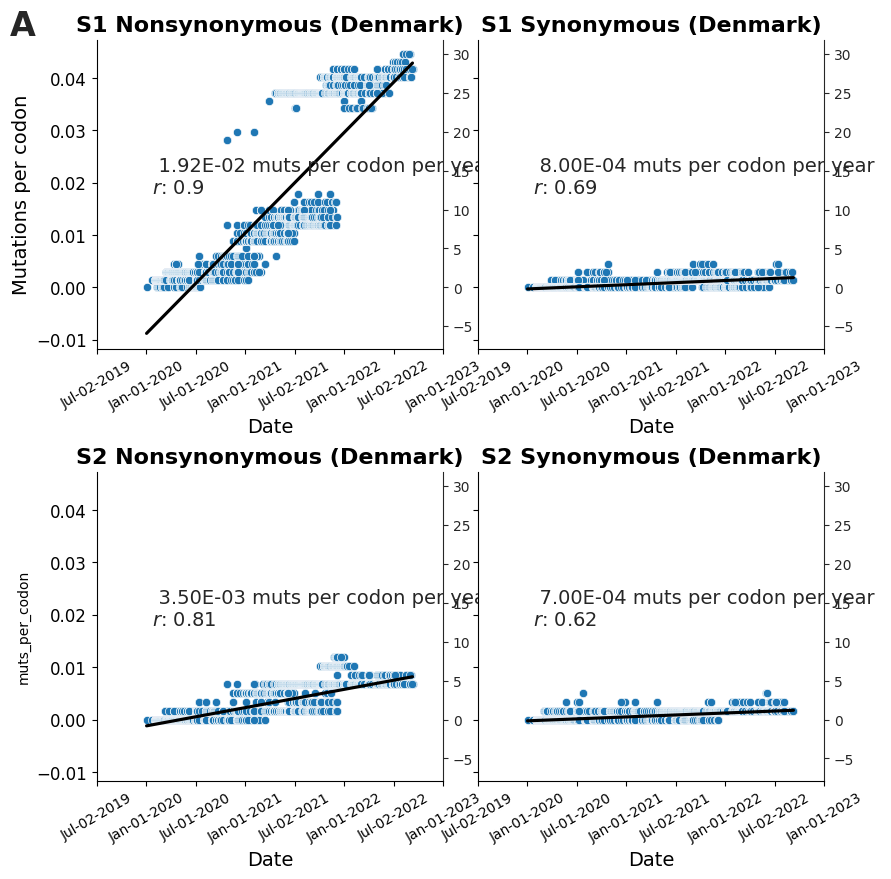

In [17]:
plot_fig1ab('mutation_Denmark_2032_S1_S2.png')

/tmp/ipykernel_3955/3641609062.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='window_start', y='num_muts', hue='mut_location', palette=cmap,


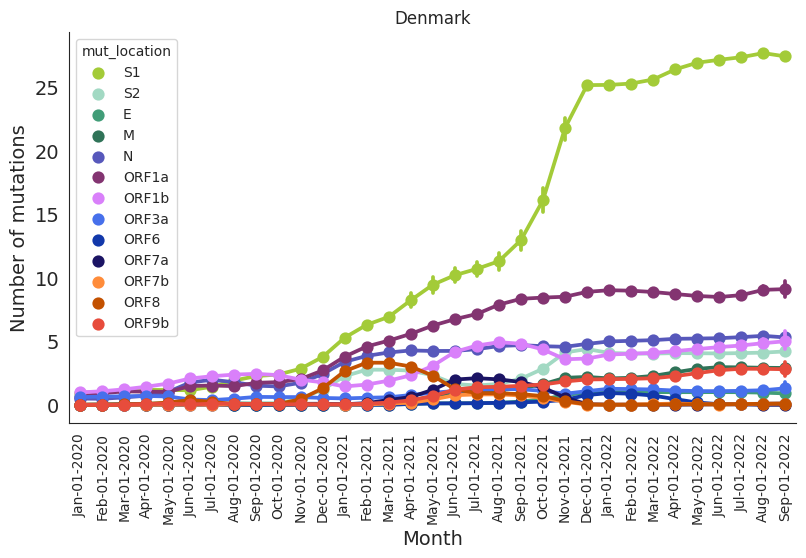

In [18]:
fig, ax = plt.subplots(figsize=(8,4.5))
plt.tight_layout()
sns.set_style("white")
sns.set_style("white")
cmap = {'S1':"#A3CB38",'S2':'#a2d9c3', 'E': '#419D78', 'M': '#307358', 
        'N': '#5758BB', 'ORF1a': '#833471', 'ORF1b':'#D980FA', 'ORF3a':'#4770eb',
      'ORF6': '#1238aa','ORF7a':'#1B1464','ORF7b':'#ff8c3a','ORF8':'#c35100','ORF9b':'#e74c3c','RBD':'#b33939'}
sns.pointplot(x='window_start', y='num_muts', hue='mut_location', palette=cmap,
              data=muts_information_df, hue_order=['S1','S2','E','M','N','ORF1a','ORF1b','ORF3a','ORF6','ORF7a',
                                              'ORF7b','ORF8','ORF9b'],
         ci=95, ax=ax)
sns.despine(left=False, bottom=False)
ax.set_xlabel('Month', fontsize=14)
plt.title('Denmark')
ax.set_ylabel('Number of mutations', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_xticks([p for p in ax.get_xticks()])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#plt.show()
fig.savefig('mutation_non_syn_num_Denmark_2032.png', dpi=300, bbox_inches='tight')

Now plot Figure: mutational fitness over time. Just for interest- This figure is not included in the paper

/tmp/ipykernel_3955/4001515027.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([DateToStr(float(t)) for t in ax.get_xticks()], rotation=30)


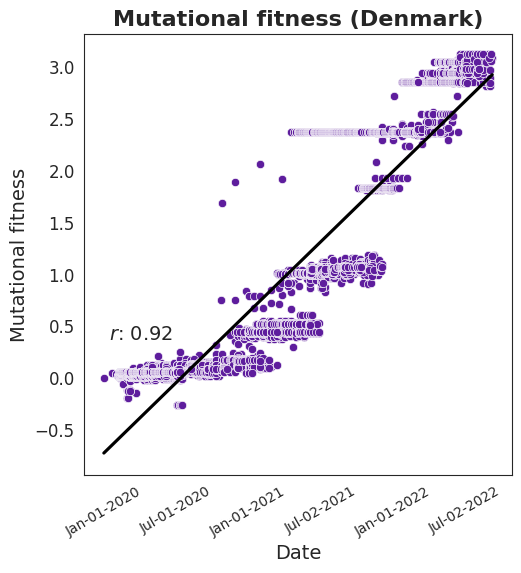

In [19]:
muts_information_df_S1=muts_information_df[muts_information_df['mut_location']=='S1']

fig, ax = plt.subplots(figsize=(5,5))
plt.tight_layout()
sns.set_style("white")

ax = sns.scatterplot(x="node_date", y="mutational_fitness", color="#5E1D9D",
                      data = muts_information_df_S1, ax=ax)
sns.regplot(x="node_date", y="mutational_fitness", scatter=False, ax=ax, 
                    data = muts_information_df_S1, 
                    line_kws={"color":'black'}, ci=95)

# run linear regression on the plot
slope, r_value = get_linear_reg_stats(muts_information_df_S1,"S1", 
                                              "node_date", 'mutational_fitness')

ax.annotate(f' $r$: {r_value}', 
                        xy=(2020.0,0.510), size=14, va='top', ha='left')
    
ax.set_xlabel("Date", fontsize = 14)
ax.set_title("Mutational fitness (Denmark)",fontsize = 16, fontweight='bold')
ax.set_xticklabels([DateToStr(float(t)) for t in ax.get_xticks()], rotation=30)
plt.setp(ax.get_xticklabels(), fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=12)          
ax.set_ylabel('Mutational fitness', fontsize = 14) 

fig.savefig('mutation_fitness_Denmark_2032.png', dpi=300, bbox_inches='tight')


In [20]:
# Group the dataframe by 'window_start' and calculate mean and standard error of the mean (SEM) for each 'location'
grouped_fit = muts_information_df_S1.groupby(['window_start','window_start_decimal']).agg({'mutational_fitness': ['mean', 'sem']}, skipna=True)


# Calculate the 95% confidence interval using the t-distribution with 2 degrees of freedom (assuming small sample size)
conf_interval = stats.t.ppf(0.975, df=2) * grouped_fit[('mutational_fitness', 'sem')]

# Add the mean and confidence interval to the grouped DataFrame
grouped_fit[('mutational_fitness', 'conf_interval_lower')] = grouped_fit[('mutational_fitness', 'mean')] - conf_interval
grouped_fit[('mutational_fitness', 'conf_interval_upper')] = grouped_fit[('mutational_fitness', 'mean')] + conf_interval

# Reset the index and move 'location' back as a column
grouped_fit.reset_index(inplace=True)
grouped_fit

#colnames
new_columns = ['window_start','window_start_decimal' ,'muts_fitness_mean', 'muts_fitness_sem', 'muts_fitness_ci_lower',
               'muts_fitness_ci_upper']
grouped_fit.set_axis(new_columns, axis=1, inplace=True)

grouped_fit



/tmp/ipykernel_3955/2444874248.py:19: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  grouped_fit.set_axis(new_columns, axis=1, inplace=True)


,window_start,window_start_decimal,muts_fitness_mean,muts_fitness_sem,muts_fitness_ci_lower,muts_fitness_ci_upper
0,Apr-01-2020,2020.248634,0.041480,0.001698,0.034176,0.048784
1,Apr-01-2021,2021.246575,0.713315,0.029330,0.587119,0.839511
2,Apr-01-2022,2022.246575,2.736738,0.017114,2.663102,2.810374
3,Aug-01-2020,2020.581967,0.097803,0.001679,0.090577,0.105028
4,Aug-01-2021,2021.580822,1.260341,0.029261,1.134439,1.386243
5,Aug-01-2022,2022.580822,2.984866,0.014425,2.922801,3.046932
6,Dec-01-2020,2020.915301,0.250241,0.009908,0.207611,0.292871
7,Dec-01-2021,2021.915068,2.245971,0.014344,2.184255,2.307686
8,Feb-01-2020,2020.084699,0.021709,0.001869,0.013665,0.029753
9,Feb-01-2021,2021.084932,0.470344,0.009910,0.427703,0.512984


In [21]:
grouped_fit['country'] = 'Denmark'
grouped_fit['seed'] = '2032'
grouped_fit.to_csv('mutation_fitness_mean_ci_Denmark_2032.csv', index=False)

/tmp/ipykernel_3955/4187634073.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='window_start', y='mutational_fitness', hue='mut_location', palette=cmap,


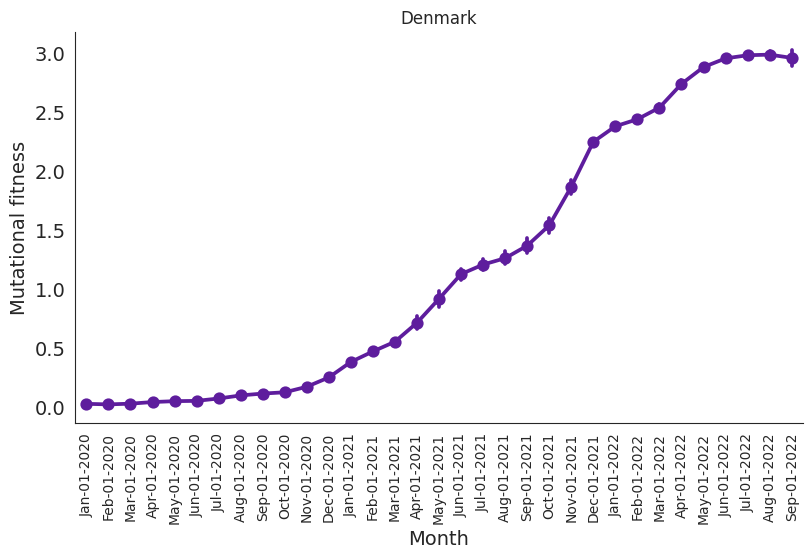

In [22]:
fig, ax = plt.subplots(figsize=(8, 4.5))
plt.tight_layout()
sns.set_style("white")
sns.set_style("white")
cmap = {'S1': "#5E1D9D"}
sns.pointplot(x='window_start', y='mutational_fitness', hue='mut_location', palette=cmap,
              data=muts_information_df, hue_order=['S1'],
              ci=95, ax=ax)
sns.despine(left=False, bottom=False)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Mutational fitness', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_xticks([p for p in ax.get_xticks()])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Denmark')
# Remove the legend
ax.get_legend().remove()

#plt.show()
fig.savefig('mutation_fitness_time_series_Denmark_2032.png', dpi=300, bbox_inches='tight')

Calculate only the internal branch for the countries of focus.

In [23]:
muts_information_df_country = muts_information_df[muts_information_df['node_country'] == 'Denmark']
muts_information_df_country

muts_information_df_country['country'] = 'Denmark'
muts_information_df_country['seed'] = '2032'
muts_information_df_country.to_csv('mutation_row_df_Denmark_2032_only_focal.csv', index=False)

/tmp/ipykernel_3955/1975038097.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muts_information_df_country['country'] = 'Denmark'
/tmp/ipykernel_3955/1975038097.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muts_information_df_country['seed'] = '2032'


In [24]:
# double check that plotted 95% confidence intervals are correct

# Group the dataframe by 'window_start' and calculate mean and standard error of the mean (SEM) for each 'location'
grouped_mut_country = muts_information_df_country.groupby(['mut_location', 'window_start','window_start_decimal']).agg({'num_muts': ['mean', 'sem']}, skipna=True)

# Calculate the 95% confidence interval using the t-distribution with 2 degrees of freedom (assuming small sample size)
conf_interval = stats.t.ppf(0.975, df=2) * grouped_mut_country[('num_muts', 'sem')]

# Add the mean and confidence interval to the grouped DataFrame
grouped_mut_country[('num_muts', 'conf_interval_lower')] = grouped_mut_country[('num_muts', 'mean')] - conf_interval
grouped_mut_country[('num_muts', 'conf_interval_upper')] = grouped_mut_country[('num_muts', 'mean')] + conf_interval

# Reset the index and move 'location' back as a column
grouped_mut_country.reset_index(inplace=True)
#grouped = grouped[['location', 'window_start', ('dn/ds', 'mean'), ('dn/ds', 'sem'), ('dn/ds', 'conf_interval_lower'), ('dn/ds', 'conf_interval_upper')]]
#print(type(grouped))

#olnames
new_columns = ['location', 'window_start','window_start_decimal' ,'muts_num_mean', 'muts_num_sem', 'muts_num_ci_lower',
               'muts_num_ci_upper']
grouped_mut_country.set_axis(new_columns, axis=1, inplace=True)

grouped_mut_country

/tmp/ipykernel_3955/2269290504.py:21: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  grouped_mut_country.set_axis(new_columns, axis=1, inplace=True)


,location,window_start,window_start_decimal,muts_num_mean,muts_num_sem,muts_num_ci_lower,muts_num_ci_upper
0,E,Apr-01-2020,2020.248634,0.017143,0.006948,-0.012753,0.047039
1,E,Apr-01-2021,2021.246575,0.069686,0.015056,0.004906,0.134467
2,E,Apr-01-2022,2022.246575,0.995305,0.004695,0.975105,1.015505
3,E,Aug-01-2020,2020.581967,0.000000,0.000000,0.000000,0.000000
4,E,Aug-01-2021,2021.580822,0.159259,0.022310,0.063265,0.255253
...,...,...,...,...,...,...,...
919,S2_synonymous,Oct-01-2020,2020.748634,0.368627,0.030271,0.238384,0.498871
920,S2_synonymous,Oct-01-2021,2021.747945,0.537572,0.027460,0.419421,0.655723
921,S2_synonymous,Sep-01-2020,2020.666667,0.299685,0.025771,0.188800,0.410569
922,S2_synonymous,Sep-01-2021,2021.665753,0.389241,0.027835,0.269475,0.509006


In [25]:
grouped_mut_country['country'] = 'Denmark'
grouped_mut_country['seed'] = '2032'
grouped_mut_country
grouped_mut_country.to_csv('mutation_mean_ci_num_Denmark_2032_only_focal.csv', index=False)

/tmp/ipykernel_3955/2418438137.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='window_start', y='num_muts', hue='mut_location', palette=cmap,


[Text(0, 0, 'Jan-01-2020'),
 Text(1, 0, 'Feb-01-2020'),
 Text(2, 0, 'Mar-01-2020'),
 Text(3, 0, 'Apr-01-2020'),
 Text(4, 0, 'May-01-2020'),
 Text(5, 0, 'Jun-01-2020'),
 Text(6, 0, 'Jul-01-2020'),
 Text(7, 0, 'Aug-01-2020'),
 Text(8, 0, 'Sep-01-2020'),
 Text(9, 0, 'Oct-01-2020'),
 Text(10, 0, 'Nov-01-2020'),
 Text(11, 0, 'Dec-01-2020'),
 Text(12, 0, 'Jan-01-2021'),
 Text(13, 0, 'Feb-01-2021'),
 Text(14, 0, 'Mar-01-2021'),
 Text(15, 0, 'Apr-01-2021'),
 Text(16, 0, 'May-01-2021'),
 Text(17, 0, 'Jun-01-2021'),
 Text(18, 0, 'Jul-01-2021'),
 Text(19, 0, 'Aug-01-2021'),
 Text(20, 0, 'Sep-01-2021'),
 Text(21, 0, 'Oct-01-2021'),
 Text(22, 0, 'Nov-01-2021'),
 Text(23, 0, 'Dec-01-2021'),
 Text(24, 0, 'Jan-01-2022'),
 Text(25, 0, 'Feb-01-2022'),
 Text(26, 0, 'Mar-01-2022'),
 Text(27, 0, 'Apr-01-2022'),
 Text(28, 0, 'May-01-2022'),
 Text(29, 0, 'Jun-01-2022'),
 Text(30, 0, 'Jul-01-2022'),
 Text(31, 0, 'Aug-01-2022'),
 Text(32, 0, 'Sep-01-2022')]

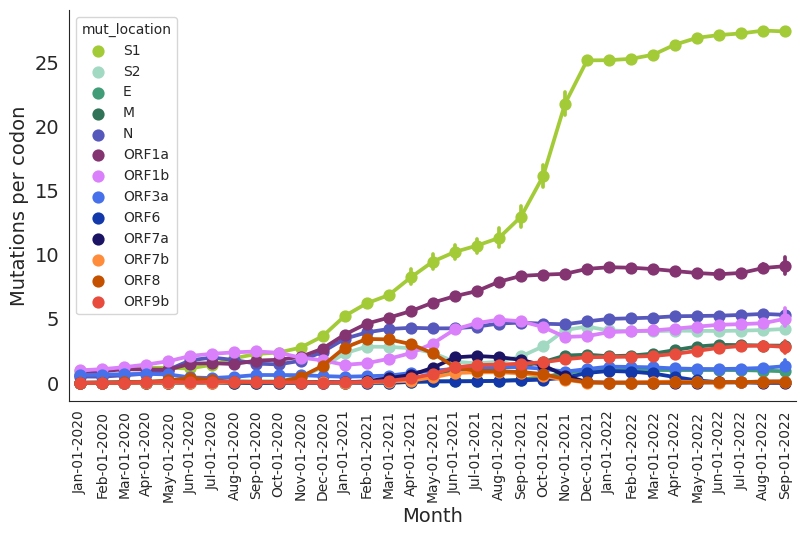

In [26]:
fig, ax = plt.subplots(figsize=(8,4.5))
plt.tight_layout()
sns.set_style("white")
sns.set_style("white")
cmap = {'S1':"#A3CB38",'S2':'#a2d9c3', 'E': '#419D78', 'M': '#307358', 
        'N': '#5758BB', 'ORF1a': '#833471', 'ORF1b':'#D980FA', 'ORF3a':'#4770eb',
      'ORF6': '#1238aa','ORF7a':'#1B1464','ORF7b':'#ff8c3a','ORF8':'#c35100','ORF9b':'#e74c3c','RBD':'#b33939'}
sns.pointplot(x='window_start', y='num_muts', hue='mut_location', palette=cmap,
              data=muts_information_df_country, hue_order=['S1','S2','E','M','N','ORF1a','ORF1b','ORF3a','ORF6','ORF7a',
                                              'ORF7b','ORF8','ORF9b'],
         ci=95, ax=ax)
sns.despine(left=False, bottom=False)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Mutations per codon', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_xticks([p for p in ax.get_xticks()])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#plt.show()

In [27]:
muts_information_df_S1_country = muts_information_df_S1[muts_information_df_S1['node_country'] == 'Denmark']
muts_information_df_S1_country

,clade,node_date,emerging_lineage,node_country,clade_membership,mutational_fitness,S1_mutations,mut_location,num_muts,muts_per_codon,num_deletions,dels_per_codon,snps_per_codon,window_start,window_start_decimal,window_end,window_midpoint,country,seed
0,NODE_0000000,2020.003614,19A,Denmark,19A,0.000000,0.0,S1,0,0.000000,0,0.000000,0.000000,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,Denmark,2032
28,NODE_0000007,2020.112139,19A,Denmark,19A,0.000000,0.0,S1,0,0.000000,0,0.000000,0.000000,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,Denmark,2032
56,NODE_0000006,2020.120836,19A,Denmark,19A,0.000000,0.0,S1,0,0.000000,0,0.000000,0.000000,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,Denmark,2032
84,NODE_0000010,2020.129783,19A,Denmark,19A,0.000000,0.0,S1,0,0.000000,0,0.000000,0.000000,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,Denmark,2032
112,NODE_0000757,2020.138660,19B,Denmark,19B,-0.060330,0.0,S1,0,0.000000,0,0.000000,0.000000,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,Denmark,2032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264376,NODE_0006159,2022.673710,22B (Omicron),Denmark,22B (Omicron),2.847271,27.0,S1,27,0.040119,2,0.002972,0.037147,Sep-01-2022,2022.665753,Oct-31-2022,Oct-01-2022,Denmark,2032
264404,NODE_0006116,2022.691330,22B (Omicron),Denmark,22B (Omicron),3.079762,28.0,S1,28,0.041605,2,0.002972,0.038633,Sep-01-2022,2022.665753,Oct-31-2022,Oct-01-2022,Denmark,2032
264432,NODE_0006158,2022.680371,22B (Omicron),Denmark,22B (Omicron),3.058502,27.0,S1,27,0.040119,2,0.002972,0.037147,Sep-01-2022,2022.665753,Oct-31-2022,Oct-01-2022,Denmark,2032
264460,NODE_0006144,2022.667108,22B (Omicron),Denmark,22B (Omicron),3.087553,28.0,S1,28,0.041605,2,0.002972,0.038633,Sep-01-2022,2022.665753,Oct-31-2022,Oct-01-2022,Denmark,2032


In [28]:

# Group the dataframe by 'window_start' and calculate mean and standard error of the mean (SEM) for each 'location'
grouped_fit_country = muts_information_df_S1_country.groupby(['window_start','window_start_decimal']).agg({'mutational_fitness': ['mean', 'sem']}, skipna=True)


# Calculate the 95% confidence interval using the t-distribution with 2 degrees of freedom (assuming small sample size)
conf_interval = stats.t.ppf(0.975, df=2) * grouped_fit_country[('mutational_fitness', 'sem')]

# Add the mean and confidence interval to the grouped DataFrame
grouped_fit_country[('mutational_fitness', 'conf_interval_lower')] = grouped_fit_country[('mutational_fitness', 'mean')] - conf_interval
grouped_fit_country[('mutational_fitness', 'conf_interval_upper')] = grouped_fit_country[('mutational_fitness', 'mean')] + conf_interval

# Reset the index and move 'location' back as a column
grouped_fit_country.reset_index(inplace=True)
grouped_fit_country

#colnames
new_columns = ['window_start','window_start_decimal' ,'muts_fitness_mean', 'muts_fitness_sem', 'muts_fitness_ci_lower',
               'muts_fitness_ci_upper']
grouped_fit_country.set_axis(new_columns, axis=1, inplace=True)

grouped_fit_country



/tmp/ipykernel_3955/1416995831.py:19: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  grouped_fit_country.set_axis(new_columns, axis=1, inplace=True)


,window_start,window_start_decimal,muts_fitness_mean,muts_fitness_sem,muts_fitness_ci_lower,muts_fitness_ci_upper
0,Apr-01-2020,2020.248634,0.041509,0.001707,0.034163,0.048854
1,Apr-01-2021,2021.246575,0.713063,0.029531,0.586000,0.840126
2,Apr-01-2022,2022.246575,2.736738,0.017114,2.663102,2.810374
3,Aug-01-2020,2020.581967,0.097043,0.001659,0.089905,0.104182
4,Aug-01-2021,2021.580822,1.260341,0.029261,1.134439,1.386243
5,Aug-01-2022,2022.580822,2.975623,0.014670,2.912502,3.038744
6,Dec-01-2020,2020.915301,0.238718,0.009549,0.197631,0.279806
7,Dec-01-2021,2021.915068,2.245971,0.014344,2.184255,2.307686
8,Feb-01-2020,2020.084699,0.023184,0.001600,0.016298,0.030071
9,Feb-01-2021,2021.084932,0.465052,0.010162,0.421330,0.508774


In [29]:
grouped_fit_country['country'] = 'Denmark'
grouped_fit_country['seed'] = '2032'
grouped_fit_country.to_csv('mutation_fitness_mean_ci_Denmark_2032_only_focal.csv', index=False)

/tmp/ipykernel_3955/3872566303.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='window_start', y='mutational_fitness', hue='mut_location', palette=cmap,


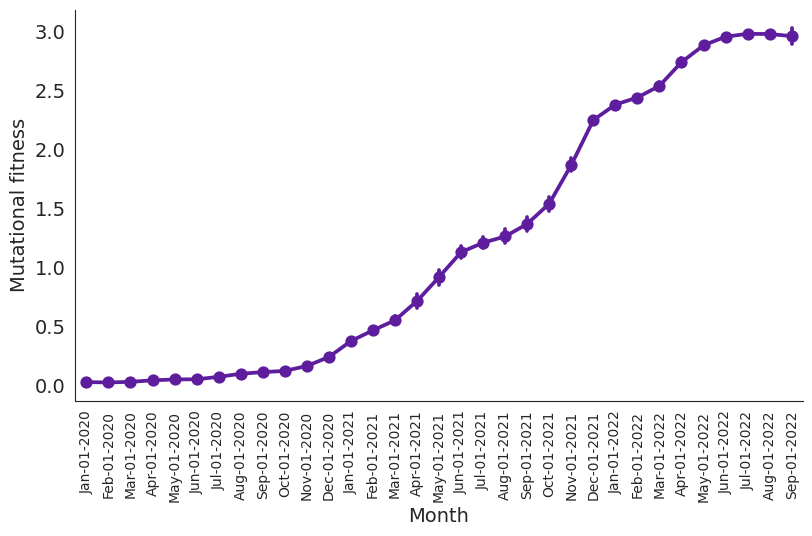

In [30]:
fig, ax = plt.subplots(figsize=(8, 4.5))
plt.tight_layout()
sns.set_style("white")
sns.set_style("white")
cmap = {'S1': "#5E1D9D"}
sns.pointplot(x='window_start', y='mutational_fitness', hue='mut_location', palette=cmap,
              data=muts_information_df_country, hue_order=['S1'],
              ci=95, ax=ax)
sns.despine(left=False, bottom=False)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Mutational fitness', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_xticks([p for p in ax.get_xticks()])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Remove the legend
ax.get_legend().remove()

#plt.show()
